# Understanding What Makes ResNets Special

Building a CNN with [ResNet](https://arxiv.org/abs/1512.03385) architecture to solve the MNIST classification task.

In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

## Preprocessing with fastai's Data Block API

First, let's download the MNIST Dataset.

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training')]

Fastai's [data block API](https://docs.fast.ai/data_block.html) offers a handy way to execute all the steps necessary to preprocess a dataset for training in a neural network (input locations, labels, train-val-test split, etc.), in basically just one line of code.

In this notebook, we'll explore in greater detail just what's going on in each preprocessing operation we apply to our MNIST data.

First, we'll quickly create a list that contains all our images.

In [4]:
il = ImageItemList.from_folder(path, convert_mode='L') # open images using Pillow's black and white mode

In [5]:
il.items[0]

PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/8/6327.png')

We can change the color map default from 'rgb' to 'binary' since our MNIST images are just black and white. This is important because as we will soon see, this our images have just one color channel, since we opened them using [Pillow's](https://pillow.readthedocs.io/en/4.2.x/reference/Image.html) "L" mode (black and white).

In [7]:
defaults.cmap='binary'

In [8]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png

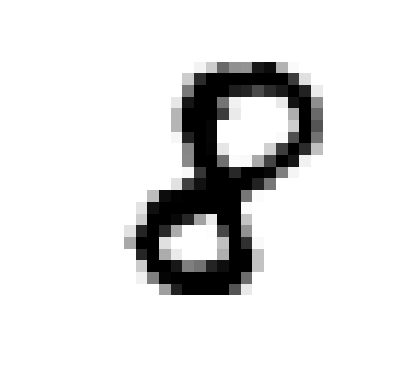

In [9]:
il[0].show()

The `split_by_folder` method allows us to designate existing folders as containing the training/validation/testing sets. For the purposes of this exercise we don't need a final test set, so we'll use our dataset's `training` and `testing` folders for its train and validation sets, respectively

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6')]

We see that inside our dataset's images are further sub-grouped into ten separate folders, where each folder corresponds to one of the ten labels (digits 0 through 9).

Fastai's `label_from_folder` method lets easily lets us use designate these folder names as the labels for our data.

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/jupyter/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/jupyter/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

Let's do a quick sanity check and grab the first image and its corresponding label from our training set.

In [15]:
x, y = ll.train[0]

8 torch.Size([1, 28, 28])


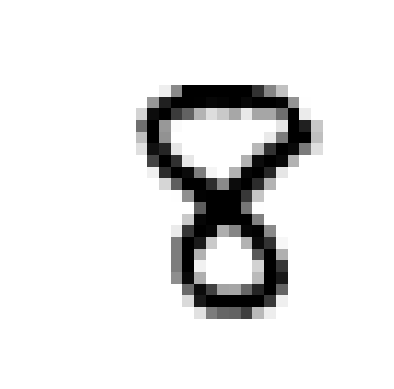

In [16]:
x.show()
print(y, x.shape)

We're almost done. The `transform` method allows us to designate the kinds of transforms we'll randomly apply to images in our training set in order to perform data augmentation.

Here, we'll randomly apply padding to images, ensuring that the background is always black, and images are cropped to 28x28.

In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # Empty list would contain transforms for val set, if we wanted

In [18]:
ll = ll.transform(tfms)

Let's set the batch size to 128.

In [19]:
bs = 128

Our data is now ready to be used for training. We wrap it with a `databunch` object, where we designate the batch size. If we were using a pre-trained model, we'd normalize using ImageNet stats. However, since we're not using transfer learning in this exercise, we only need to apply standard normalization.

In [20]:
data = ll.databunch(bs=bs).normalize()

One final sanity check to ensure that our images are being stored and randomly augmented in the manner we'd expect.

In [21]:
x,y = data.train_ds[0]

8


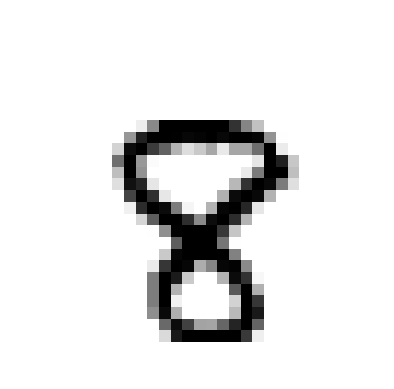

In [23]:
x.show()
print(y)

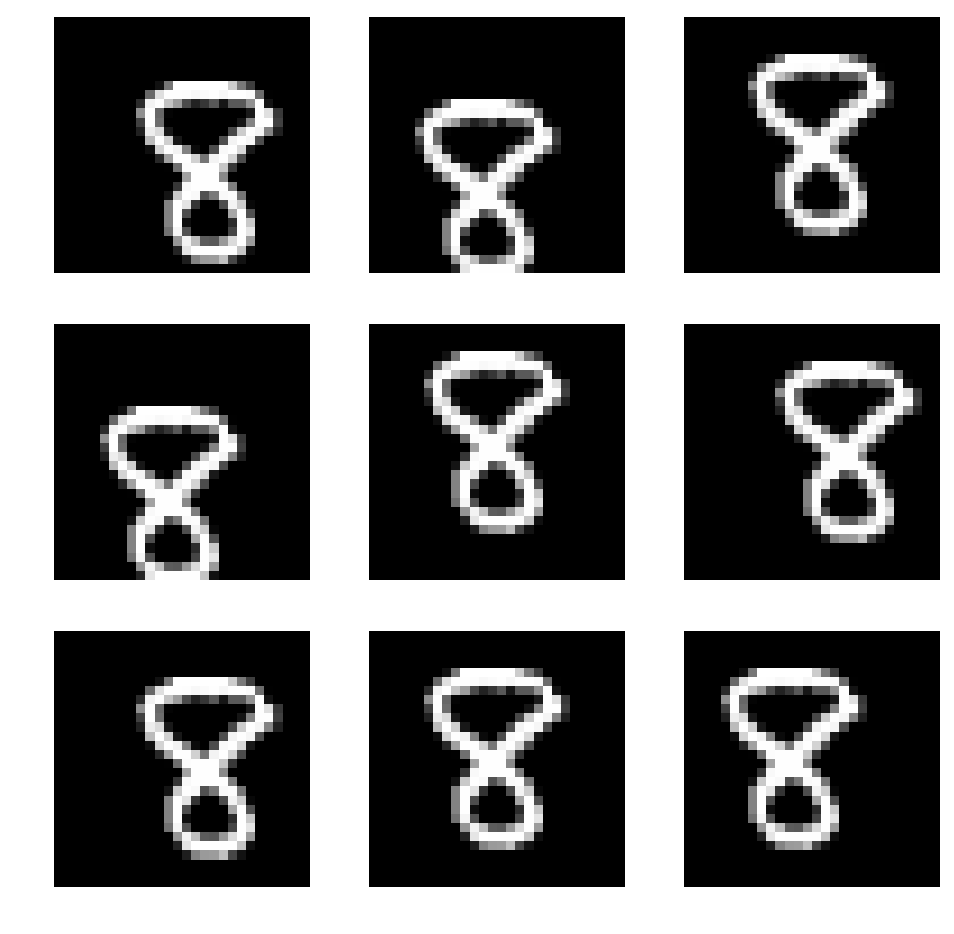

In [24]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

Let's also grab one batch and make sure everything checks out.

In [25]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

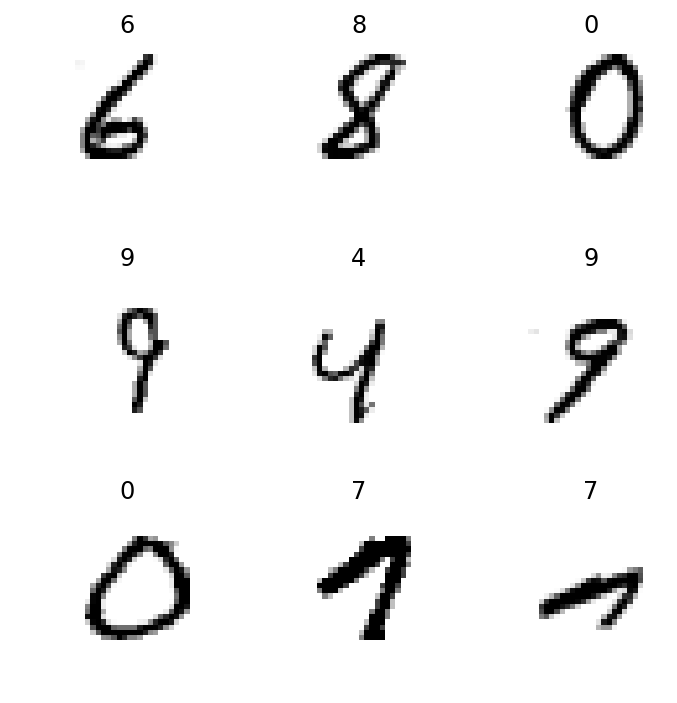

In [26]:
data.show_batch(rows=3, figsize=(5,5))

## Creating and training a basic CNN with batchnorm

The goal of this notebook is to understand the ResNet architecture. A great way to do this is to first create and train a traditional CNN from scratch, and then build a CNN that employs ResNet characteristics, and compare the two approaches.

First, we define our convolutional layers.

In [27]:
def conv(ni, nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

Next, we outline our network's architecture.

In [28]:
model = nn.Sequential(
    conv(1,8),   # 14x14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16),  # 7x7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32), # 4x4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16), # 2x2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10), # 1x1
    nn.BatchNorm2d(10),
    Flatten()    # remove the (1,1) grid
)

In [30]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [32]:
xb = xb.cuda()

In [33]:
model(xb).shape

torch.Size([128, 10])

Use learning rate finder to find the optimal learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


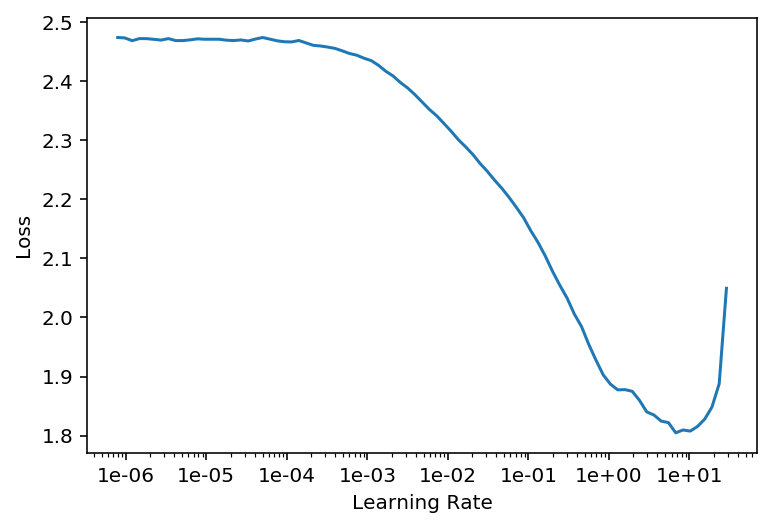

In [34]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.227518,0.180438,0.942900
2,0.131197,0.092229,0.969200
3,0.067396,0.040904,0.987100


## Refactor our basic CNN

Refactoring network models is almost never done in most code that accompanies research papers, but it's very important that we nonetheless get into the habit of doing this. Refactored code has less redundancies, is simpler, and thus has a lower chance of having bugs.

Here, we'll rewrite our model using PyTorch's `conv_layer` class, which allows us to omit `nn.BatchNorm2d()` and `nn.ReLU()`, since these are both included in layers created with `conv_layer`.

In [36]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [43]:
# Much easier to see how number if input/output channels vary 
# over our model.

model = nn.Sequential(
    conv2(1,8),   # 14x14
    conv2(8,16),  # 7x7
    conv2(16,32), # 4x4
    conv2(32,16), # 2x2
    conv2(16,10), # 1x1
    Flatten()     # remove (1,1) grid
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [45]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.234906,0.188805,0.941400
2,0.190297,0.229616,0.924800
3,0.154641,0.127442,0.958100
4,0.134910,0.097451,0.968200
5,0.118486,0.166093,0.953100
6,0.098162,0.132190,0.957900
7,0.092222,0.053411,0.982600
8,0.061054,0.040187,0.987200
9,0.052706,0.029349,0.990800
10,0.048193,0.027639,0.991800


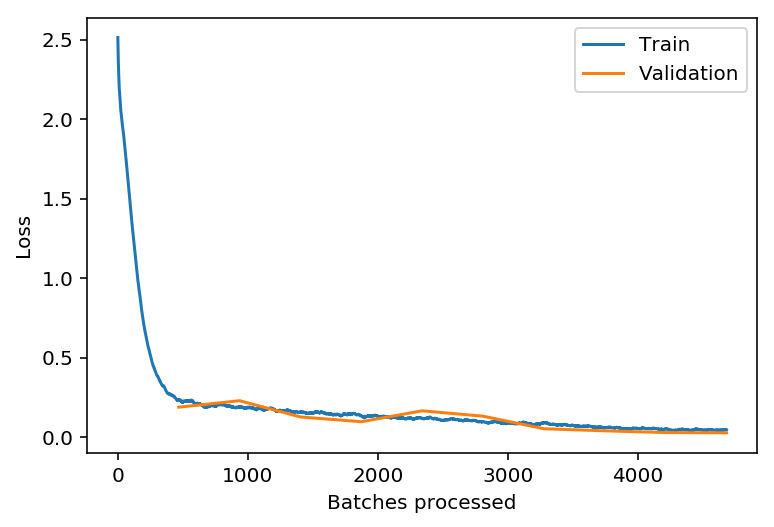

In [47]:
learn.recorder.plot_losses()

## CNN with ResNet Architecture

We'll now build a CNN that contains ResNet blocks. ResNet blocks allow us to build much deeper networks without having to worry about vanishing gradients. 

![resnet block](images/lesson7-resnet-mnist-my-reimplementation/resnet_block.png)

The innovation is that each ResNet block contains an identity shortcut, or "skip connection," that allows weight updates to be passed directly behind the two convolutional layers inside the ResNet block. The outcome is that weights in the early layers of the network can be successfully trained, even if the network is very, very deep.

Vincent Fung's [writeup](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) contains a great summary.

Now let's see what a ResNet block looks like in code.

In [48]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

Oftentimes, actually implementing a concept in code reveals that it is actually quite a deal more straightfoward and intuitive than written explanations or diagrams may at first glance make it seem.

Now we'll update the basic CNN we built and trained earlier, this time using our `ResBlock` class to include skip connections.

In [50]:
model = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [51]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


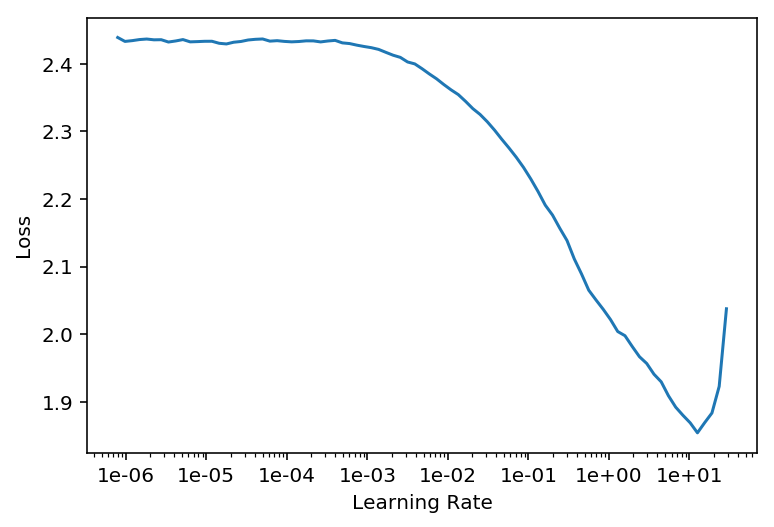

In [52]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(3, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.187314,0.183755,0.947200
2,0.090484,0.050604,0.985300
3,0.037119,0.024633,0.992400


Our CNN with ResNet blocks already is doing much better than the standard CNN did, getting to an accuracy above `0.99` after only 3 epochs. Our standard CNN only got to `0.987` at this point.

We can further refactor our model that contains ResNet blocks.

In [61]:
def conv_and_res(ni, nf):
    return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [62]:
model = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [63]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [64]:
learn.fit_one_cycle(10, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.226643,0.187060,0.942400
2,0.137861,0.282789,0.911200
3,0.099504,0.122584,0.962900
4,0.093935,0.165717,0.949800
5,0.064675,0.089931,0.972500
6,0.065131,0.084586,0.973800
7,0.044157,0.024622,0.992800
8,0.029531,0.026492,0.991700
9,0.027478,0.017245,0.994500
10,0.021837,0.015908,0.994600


After 10 epochs, our ResNet block CNN's accuracy of `0.995` continues to exceed the accuracy of `0.992` that our standard CNN achieved by this point

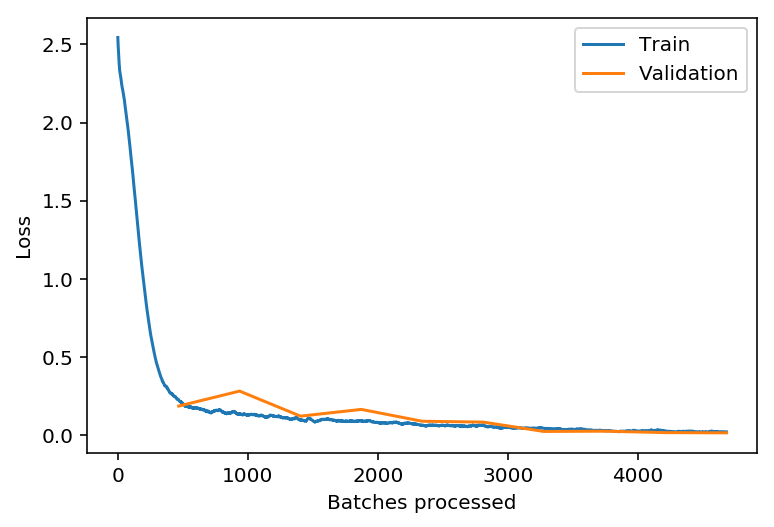

In [65]:
learn.recorder.plot_losses()

Finally, let's take a look at the structure of our ResNet block model. We will see that our refactored model indeed allowed us to describe a fairly extensive network, in just a few lines of code.

In [66]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________